In [2]:
import matplotlib.pyplot as plt
import numpy
import os
import pandas

import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.models import Sequential
from keras.layers import Dense

import sklearn.utils

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

sans_models = ['sphere', 'core_shell_sphere', 'ellipsoid', 'core_shell_ellipsoid', 'cylinder', 'core_shell_cylinder', 'three_pearl_necklace', 'lamellar', 'lamellar_hg']
# sans_models = ['core_shell_cylinder', 'core_shell_cylinder', 'core_shell_cylinder', 'core_shell_cylinder']

# load training data
data_x_pandas = []
data_y_pandas = []
data_x = None
data_x2 = None
data_y = None
ydim = []
for sansmodel in sans_models:
    print(sansmodel)
    data_x_pandas.append(fnLoadObject('training_data/train_'+sansmodel+'_x.dat'))
    data_y_pandas.append(fnLoadObject('training_data/train_'+sansmodel+'_y.dat'))
    # number of parameters knowing that scale and sld_solvent will be dropped
    ydim.append(data_y_pandas[-1][0].shape[0]-2)

# list of lists of parameter names for each sans model
# scale and solvent SLDs are currently excluded, as they are not predicted
parname_list = []
for i in range(len(sans_models)):
    templist = []
    for j in range(data_y_pandas[i][0].shape[0]):
        parname = data_y_pandas[i][0]['par'].iloc[j]
        if parname != 'scale' and parname != 'sld_solvent':
            templist.append(parname)
    parname_list.append(templist)

sphere
core_shell_sphere
ellipsoid
core_shell_ellipsoid
cylinder
core_shell_cylinder
three_pearl_necklace
lamellar
lamellar_hg


In [2]:
# Data preparation, encode all regression outputs: only the output associated with the target model of the data has non-zeror values.
# The classification output is in one hot encoding.
def y_encode(model, ydata, modellist, ydim):
    def onehot(y_cl, num_classes):
        y = numpy.zeros((len(y_cl), num_classes))
        y[numpy.arange(len(y_cl)), y_cl] = 1
        return y

    result = []
    class_number = None
    for i, modelname in enumerate(modellist):
        # regression outputs
        if model == modelname:
            # fill output for particular model with training values
            result.append(ydata)
            class_number = i
        else:
            # the outputs for the other models are set to zero
            result.append(numpy.zeros(shape=(ydata.shape[0], ydim[i])).astype('float32'))

    # classification output, one-hot encoding for the particular model
    oh = numpy.full((ydata.shape[0]), class_number)
    oh = onehot(oh, len(modellist)).astype('float32')
    result.append(oh)

    return result


# data augmentation
for i, sansmodel in enumerate(sans_models):

    parlist = data_y_pandas[i][0]['par'].values.tolist()
    modparlist = []
    for par in parlist:
        if 'sld' in par and par != 'sld_solvent':
            modparlist.append(par)

    new_x = numpy.row_stack([frame['I'].to_numpy() for frame in data_x_pandas[i]])
    new_x = numpy.log10(new_x).astype('float32')
    # second input with scale and sld_solvent par values
    new_x2 = numpy.empty(shape=(len(data_y_pandas[i]), 2)).astype('float32')

    for j, frame in enumerate(data_y_pandas[i]):
        # amplify slds by a factor of 10
        for par in modparlist:
            sld = frame.loc[frame.par == par, 'value'].squeeze()
            frame.loc[frame.par == par, 'value'] = sld * 10.0

        new_x2[j, 0] = frame.loc[frame.par =='scale', 'value'].squeeze()
        new_x2[j, 1] = frame.loc[frame.par =='sld_solvent', 'value'].squeeze()
        # remove solvent sld and scale factor, since they cannot be resolved
        index_names = frame[ frame['par'] == 'scale'].index
        frame.drop(index_names, inplace = True)
        index_names = frame[ frame['par'] == 'sld_solvent'].index
        frame.drop(index_names, inplace = True)

    new_y = numpy.row_stack([frame['value'].to_numpy() for frame in data_y_pandas[i]]).astype('float32')
    new_y = y_encode(sansmodel, new_y, sans_models, ydim)

    if data_x is None:
        data_x = new_x
        data_x2 = new_x2
    else:
        data_x = numpy.concatenate((data_x, new_x), axis=0)
        data_x2 = numpy.concatenate((data_x2, new_x2), axis=0)

    if data_y is None:
        data_y = new_y
    else:
        for j in range(len(sans_models)+1):
            data_y[j] = numpy.concatenate((data_y[j], new_y[j]), axis=0)

# Prepare for proper training
# randomly sort examples
data_y.append(data_x)
data_y.append(data_x2)
data_y = sklearn.utils.shuffle(*data_y, random_state=0)
data_x = data_y[-2]
data_x2 = data_y[-1]
data_y = data_y[:-2]
pass

sphere
core_shell_sphere
ellipsoid
core_shell_ellipsoid
cylinder
core_shell_cylinder
three_pearl_necklace
lamellar
lamellar_hg


In [3]:
# model construction
input1_dim = data_x.shape[1]
input2_dim = data_x2.shape[1]
n_input_layers = 4
n_regression_layers = 10
n_classification_layers = 6
output_layers = []

node_n = input1_dim
node_n2 = int(numpy.sqrt((input1_dim + input2_dim) * 10))

activation = "relu"
reg_strategy = keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)  # use L1 and L2 regularization

# common input layers
sans_input = keras.Input(shape=(input1_dim, ))
x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(sans_input)
x = layers.Dense(node_n, activation=activation, kernel_regularizer=reg_strategy)(x)

for _ in range(n_input_layers):
    x = layers.Dense(int(0.66 *node_n), activation=activation, kernel_regularizer=reg_strategy)(x)

par_input = keras.Input(shape=(input2_dim, ))
x2 = layers.Dense(input2_dim, activation=activation, kernel_regularizer=reg_strategy)(par_input)

conc_layer = layers.concatenate([x, x2])

# split into different model regression layers plus classification
# regression
for j, sans_model in enumerate(sans_models):
    x3 = layers.Dense(node_n2, activation=activation, kernel_regularizer=reg_strategy)(conc_layer)
    for i in range(n_regression_layers-1):
        x3 = layers.Dense(node_n2, activation=activation, kernel_regularizer=reg_strategy)(x3)
    output_layers.append(Dense(data_y[j].shape[1], activation="linear")(x3))

# classification
x3 = layers.Dense(node_n2, activation=activation, kernel_regularizer=reg_strategy)(conc_layer)
for _ in range(n_classification_layers-1):
    x3 = layers.Dense(node_n2, activation=activation, kernel_regularizer=reg_strategy)(x3)
output_layers.append(Dense(len(sans_models), activation="softmax")(x3))

#model

model = keras.Model(
    inputs=[sans_input, par_input],
    outputs=output_layers,
)


In [4]:
# Regression loss is per individual model output. Only return a non-zero loss if not all
# true values are zero. All-zero values mean that the current model belonged to the different
# sans model than what the current model output is associated with.
def fn_regression_loss(y_true, y_pred):
    # rank = tf.rank(y_true)
    # if rank == 2:
    pattern = tf.zeros_like(y_true[0])
    shape = y_true.shape[1]
    mask = tf.math.equal(y_true, pattern)
    split = tf.split(mask, num_or_size_splits=shape, axis=1)

    '''
        else:
        # unsure this function will ever get a one-dimensional vector
        pattern = tf.zeros_like(y_true)
        shape = y_true.shape[0]
        mask = tf.math.equal(y_true, pattern)
        split = tf.split(mask, num_or_size_splits=shape, axis=0)
    '''

    y_mult = split[0]
    for i in range(1, shape):
        y_mult = tf.math.logical_and(y_mult, split[i])
    y_mult = tf.where(y_mult, 0., 1.)

    mse = tf.reduce_mean((tf.squeeze(y_pred)-tf.squeeze(y_true))**2, axis=1)
    mse_masked = tf.math.multiply(tf.squeeze(mse), tf.squeeze(y_mult))
    result = tf.reduce_mean(mse_masked)

    return result

opt = keras.optimizers.Adam(learning_rate=0.0003)
losslist = [fn_regression_loss] * len(sans_models)
losslist.append(keras.losses.CategoricalCrossentropy(from_logits=False))
loss_w = [1.] * len(sans_models)
loss_w = loss_w.append(5.)

model.compile(optimizer=opt, loss=losslist, loss_weights=loss_w)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 105)          11130       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 105)          11130       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 69)           7314        ['dense_1[0][0]']                
                                                                                              

In [5]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
epochs_n = 1000
batch_size = 64

save_period = 20  # after how many epochs the model should be saved?
chkpnt_saver = keras.callbacks.ModelCheckpoint("weights-{epoch:02d}.hdf5",
                                               save_weights_only=False,
                                               save_freq='epoch')


history = model.fit([data_x, data_x2], data_y,
                    epochs=epochs_n,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split = 0.3,
                    shuffle=False,
                    callbacks=[chkpnt_saver]
                    )


Epoch 1/1000
985/985 [==============================] - 17s 7ms/step - loss: 2643.4626 - dense_17_loss: 157.6031 - dense_28_loss: 225.4220 - dense_39_loss: 245.9778 - dense_50_loss: 158.4225 - dense_61_loss: 229.7089 - dense_72_loss: 276.0280 - dense_83_loss: 1120.1035 - dense_94_loss: 189.6235 - dense_105_loss: 36.8146 - dense_112_loss: 2.2033 - val_loss: 1924.4326 - val_dense_17_loss: 106.4286 - val_dense_28_loss: 192.2673 - val_dense_39_loss: 187.5112 - val_dense_50_loss: 126.4357 - val_dense_61_loss: 183.2845 - val_dense_72_loss: 221.8341 - val_dense_83_loss: 746.4155 - val_dense_94_loss: 125.2949 - val_dense_105_loss: 31.6450 - val_dense_112_loss: 2.2012
Epoch 2/1000
985/985 [==============================] - 6s 6ms/step - loss: 1737.7319 - dense_17_loss: 69.7642 - dense_28_loss: 182.8580 - dense_39_loss: 164.9872 - dense_50_loss: 122.0125 - dense_61_loss: 164.1700 - dense_72_loss: 220.3977 - dense_83_loss: 691.2434 - dense_94_loss: 86.8860 - dense_105_loss: 32.2199 - dense_112_lo

In [7]:
# save ML model to disk
dirname = 'ml_model'
model.save(dirname)

INFO:tensorflow:Assets written to: ml_model\assets


INFO:tensorflow:Assets written to: ml_model\assets


In [3]:
# save model list and parname list into the same directory
fnSaveObject(sans_models, os.path.join(dirname, 'sans_models.dat'))
fnSaveObject(parname_list, os.path.join(dirname, 'par_names.dat'))

In [8]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution
train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

In [9]:
print(history.history.keys())

dict_keys(['loss', 'dense_17_loss', 'dense_28_loss', 'dense_39_loss', 'dense_50_loss', 'dense_61_loss', 'dense_72_loss', 'dense_83_loss', 'dense_94_loss', 'dense_105_loss', 'dense_112_loss', 'val_loss', 'val_dense_17_loss', 'val_dense_28_loss', 'val_dense_39_loss', 'val_dense_50_loss', 'val_dense_61_loss', 'val_dense_72_loss', 'val_dense_83_loss', 'val_dense_94_loss', 'val_dense_105_loss', 'val_dense_112_loss'])


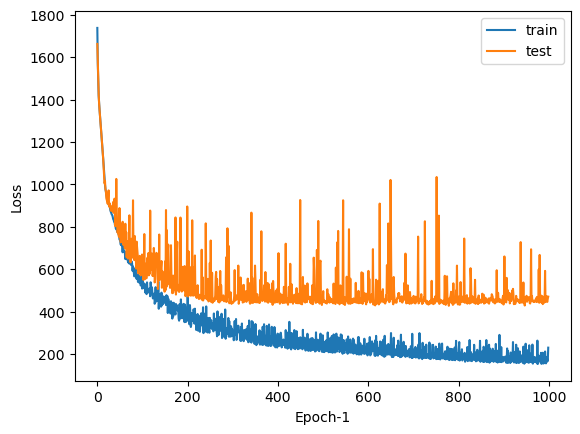

In [10]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.show()

In [11]:
# After the training:

# Prepare scatter plot
y_pred = model.predict([data_x, data_x2])


2813/2813 [==============================] - 3s 1ms/step


In [12]:
y_pred

[array([[173.61699  ,  -0.6661587],
        [139.30684  ,  12.367259 ],
        [151.92834  ,  22.91108  ],
        ...,
        [ 18.995317 ,  45.079525 ],
        [ 46.565887 ,  33.383026 ],
        [ 83.31349  ,  61.543674 ]], dtype=float32),
 array([[ 30.85674  ,  19.892914 ,   2.0833464, 144.58443  ],
        [117.86363  ,  -1.0640492,  43.447124 , 113.68323  ],
        [109.81667  ,  21.852646 ,  17.160019 , 114.12559  ],
        ...,
        [ 17.687908 ,  16.06944  ,  48.84412  ,  26.583635 ],
        [ 18.25388  ,  17.460644 ,  44.778896 ,  22.338467 ],
        [ 43.26018  ,  40.474552 ,  55.206257 ,  53.197067 ]],
       dtype=float32),
 array([[168.51569  , 165.7587   ,  -3.864671 ],
        [114.61689  , 225.44014  ,  -2.0145466],
        [194.85378  , 104.11324  ,  21.556328 ],
        ...,
        [ 15.648592 ,  89.35305  ,  53.310364 ],
        [ 40.894215 ,  62.944096 ,  42.512596 ],
        [ 78.923225 ,  84.69927  ,  67.612114 ]], dtype=float32),
 array([[ 83.42586  ,

62999
radius
Correlation coefficient: [[1.         0.08839771]
 [0.08839771 1.        ]]


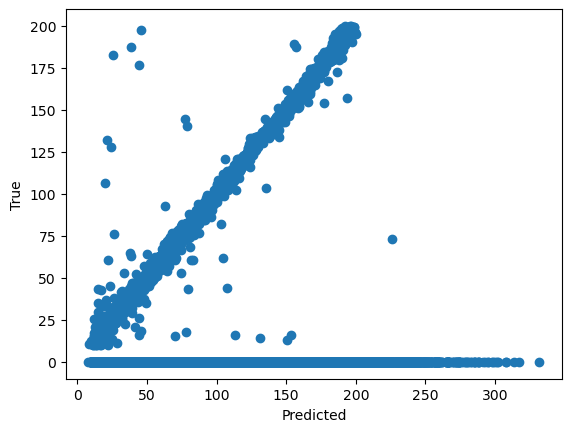

sld
Correlation coefficient: [[1.         0.19532996]
 [0.19532996 1.        ]]


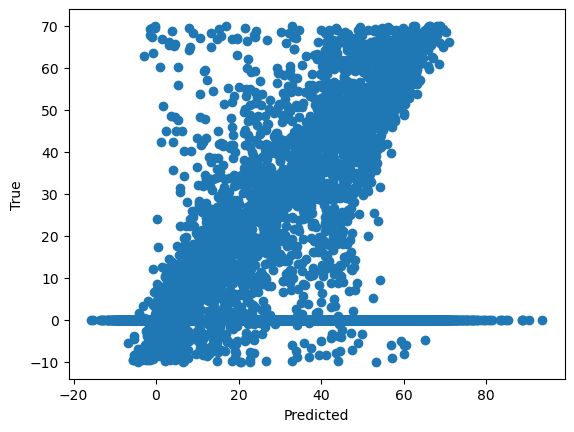

In [13]:
# sphere
j = 0
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius
Correlation coefficient: [[1.         0.31768528]
 [0.31768528 1.        ]]


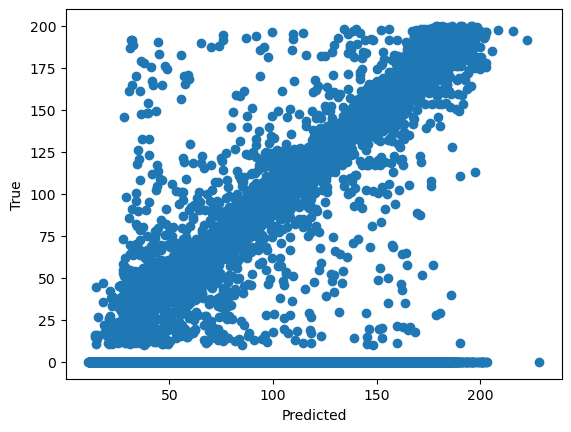

sld_core
Correlation coefficient: [[1.         0.10437968]
 [0.10437968 1.        ]]


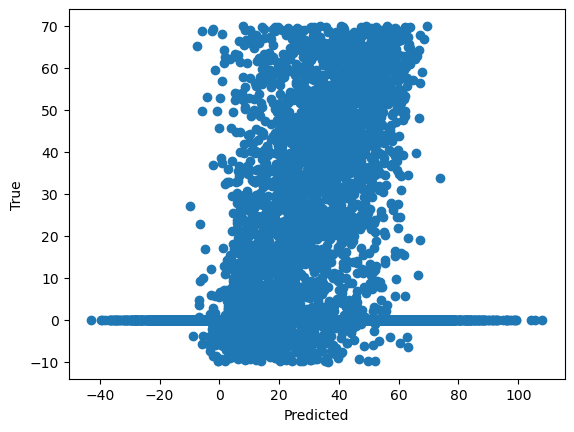

sld_shell
Correlation coefficient: [[1.         0.16171405]
 [0.16171405 1.        ]]


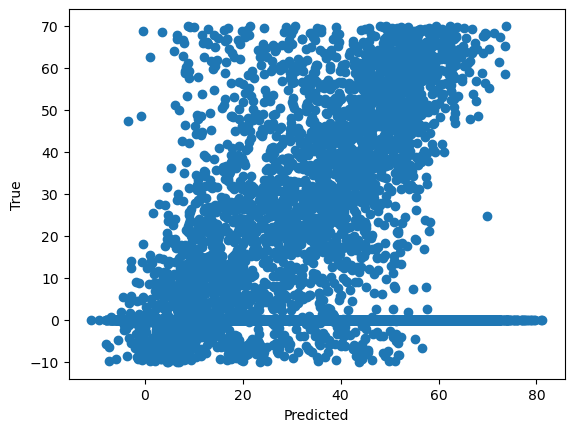

thickness
Correlation coefficient: [[1.         0.24530412]
 [0.24530412 1.        ]]


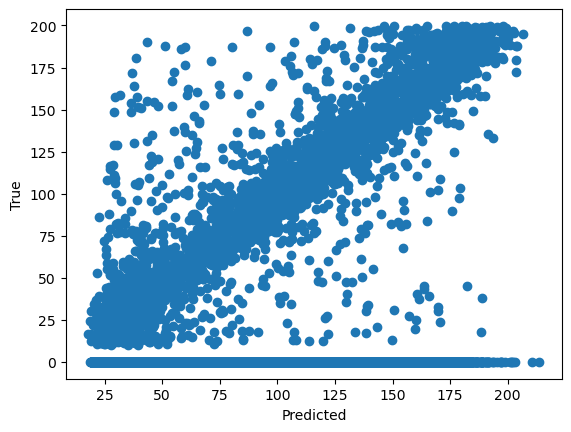

In [14]:
# core shell sphere
j = 1
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius_equatorial
Correlation coefficient: [[ 1.         -0.02194756]
 [-0.02194756  1.        ]]


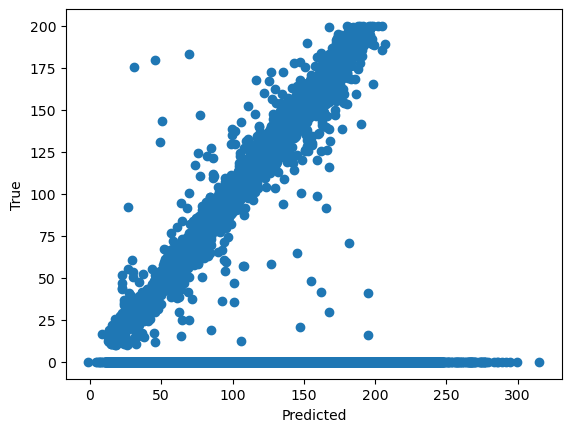

radius_polar
Correlation coefficient: [[1.         0.05231207]
 [0.05231207 1.        ]]


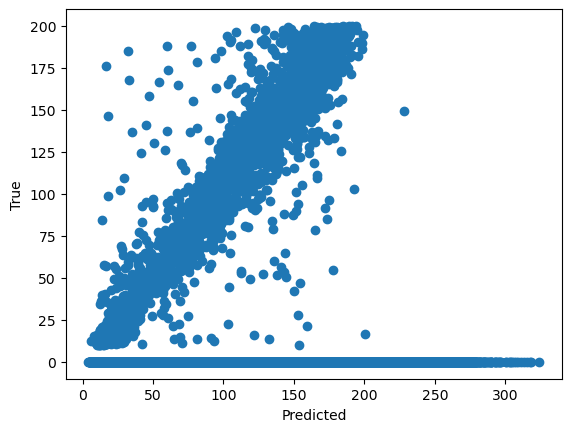

sld
Correlation coefficient: [[1.         0.15315291]
 [0.15315291 1.        ]]


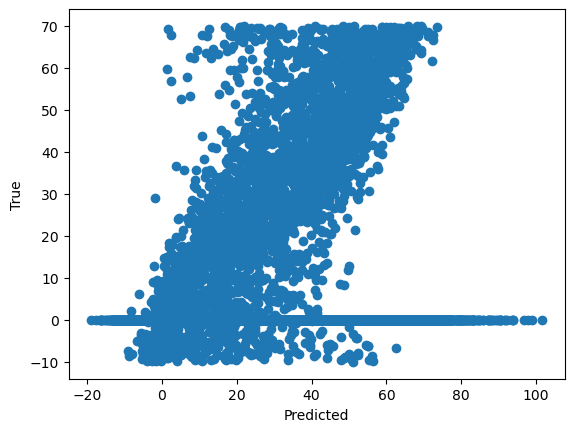

In [15]:
# ellipsoid
j = 2
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

62999
radius_equat_core
Correlation coefficient: [[1.         0.27732624]
 [0.27732624 1.        ]]


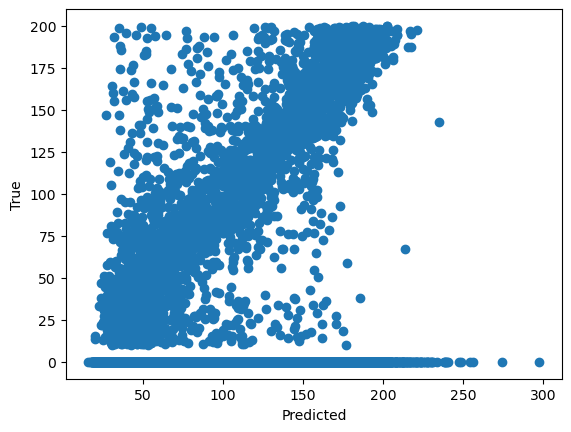

sld_core
Correlation coefficient: [[1.         0.11518642]
 [0.11518642 1.        ]]


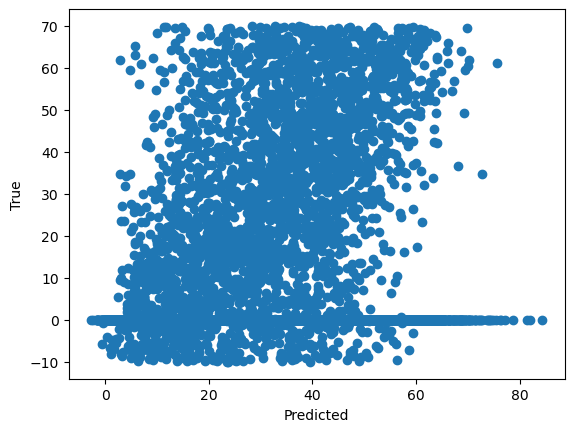

sld_shell
Correlation coefficient: [[1.         0.12967464]
 [0.12967464 1.        ]]


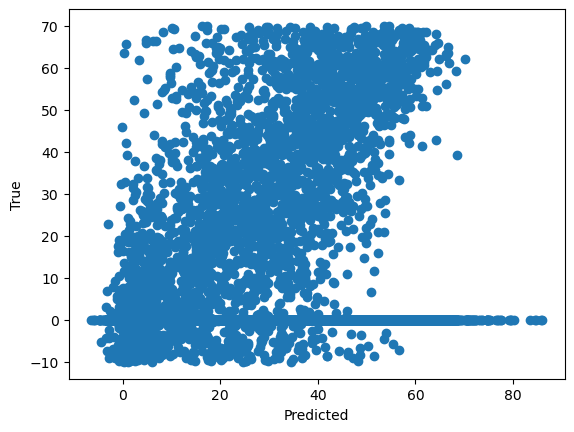

thick_shell
Correlation coefficient: [[1.         0.28349896]
 [0.28349896 1.        ]]


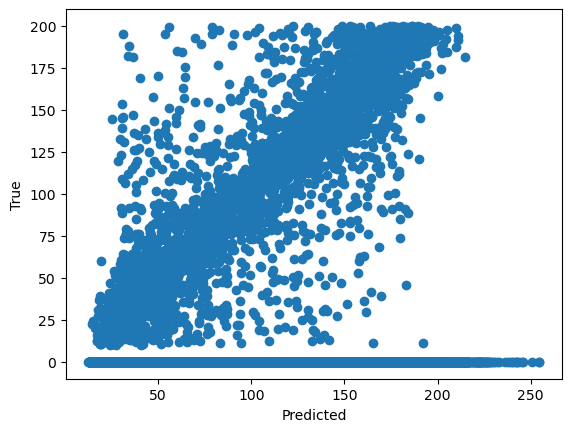

x_core
Correlation coefficient: [[1.       0.023471]
 [0.023471 1.      ]]


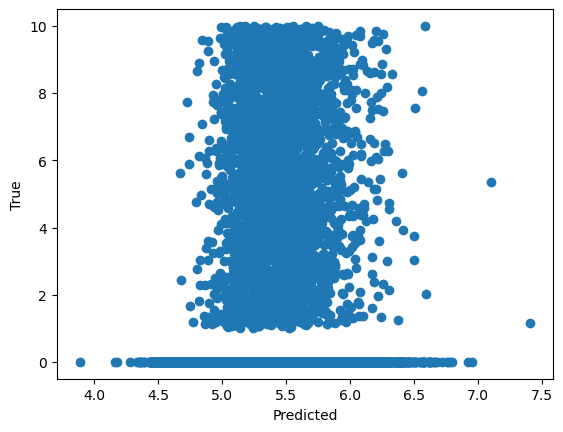

x_polar_shell
Correlation coefficient: [[1.         0.10695405]
 [0.10695405 1.        ]]


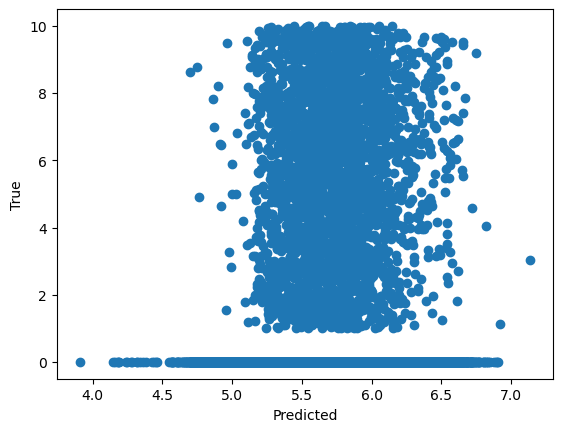

In [16]:
# core shell ellipsoid
j = 3
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
for i in range(y_pred[j].shape[1]):
    print(data_y_pandas[j][0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[j][valstart:, i],data_y[j][valstart:, i]))
    plt.scatter(y_pred[j][valstart:, i],data_y[j][valstart:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [17]:
len(data_y_pandas)

9

In [18]:
# class labels
j = 9
valstart = int(0.7 * y_pred[j].shape[0])
print(valstart)
true_class = tf.argmax(data_y[j][valstart:, :], 1)
pred_class = tf.argmax(y_pred[j][valstart:, :], 1)
cmatrix = tf.math.confusion_matrix(true_class, pred_class)

# normalization
cmatrix = cmatrix / numpy.sum(cmatrix) * float(cmatrix.shape[0])
cmatrix

62999


<tf.Tensor: shape=(9, 9), dtype=float64, numpy=
array([[8.59968149e-01, 1.49994445e-02, 1.73326914e-02, 6.66641976e-04,
        2.49990741e-02, 6.66641976e-04, 6.49975927e-02, 2.99988889e-03,
        1.99992593e-03],
       [1.53660976e-01, 6.73308396e-01, 9.99962964e-03, 2.09992223e-02,
        1.13329136e-02, 9.23299137e-02, 3.63319877e-02, 3.99985186e-03,
        4.66649383e-03],
       [2.07658976e-01, 6.33309877e-03, 4.71982519e-01, 3.33320988e-03,
        2.82322877e-01, 7.99970371e-03, 3.79985926e-02, 2.99988889e-03,
        1.33328395e-03],
       [4.66649383e-03, 2.53323951e-02, 4.13318025e-02, 7.76304581e-01,
        1.86659753e-02, 1.09995926e-01, 2.13325432e-02, 1.16662346e-02,
        4.99981482e-03],
       [7.83304322e-02, 1.33328395e-03, 1.50661087e-01, 1.33328395e-03,
        7.00974038e-01, 3.66653087e-03, 2.93322470e-02, 6.99974075e-03,
        8.33302470e-03],
       [1.26661975e-02, 6.83308026e-02, 6.13310618e-02, 1.19662235e-01,
        9.56631236e-02, 6.03977630e

In [19]:
data_x2

array([[0.04518061, 5.084799  ],
       [0.08691726, 4.7952347 ],
       [0.05228884, 2.3033626 ],
       ...,
       [0.04940345, 0.10374206],
       [0.06482127, 4.114506  ],
       [0.05842435, 0.2453715 ]], dtype=float32)